# 1D Guassian Mixture Model

References:


- [Andrew Ng CS229 Lecture 14 EM algorithm](https://www.youtube.com/watch?v=rVfZHWTwXSA&list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU&index=14)
- [EM Aklgorithm and how it work](https://www.youtube.com/watch?v=REypj2sy_5U&t=1s)
- [Gaussian Mixture model Medium post](https://medium.com/swlh/gaussian-mixture-models-gmm-1327a2a62a)


In [10]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Normal
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 

In [2]:
# Generate sets of normal distributed samples
num_sample = 20


class dataset: 
    def __init__(self,num_sample): 
        self.x = torch.linspace(-5, 5, num_sample)
        self.x1 = self.x*torch.rand(num_sample)+5
        self.x2 = self.x*torch.rand(num_sample) + 15

    def __getitem__(self,index):
        return torch.cat((self.x1,self.x2), dim=0)[index]

(0.0, 20.0)

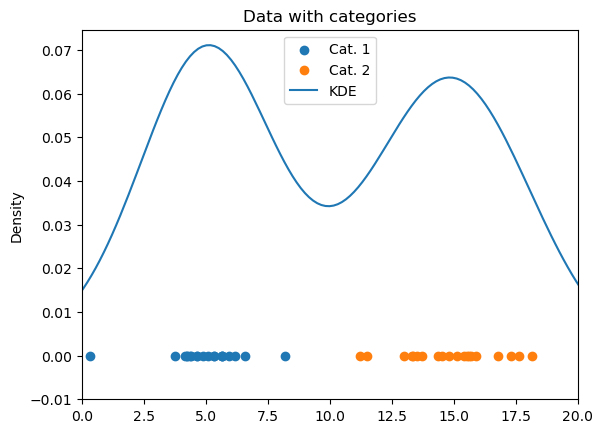

In [3]:
# get the dataset 
data =  dataset(num_sample)[:]

# Plot the data and Kernel Density Estimate (KDE)
plt.title('Data with categories')
plt.scatter(data[:20], [0]*20, label="Cat. 1")
plt.scatter(data[20:], [0]*20, label="Cat. 2")
sns.kdeplot(data, label="KDE") # KDE of data
plt.legend()
plt.ylim(bottom = -0.01)
plt.xlim(0,20)

(0.0, 20.0)

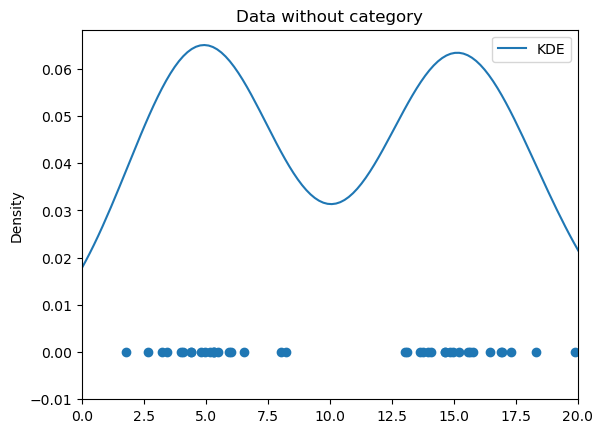

In [4]:
# get the dataset 
data =  dataset(num_sample)[:]

# Plot the data and Kernel Density Estimate (KDE)
plt.title('Data without category')
plt.scatter(data[:], [0]*40)
sns.kdeplot(data, label="KDE") # KDE of data
plt.legend()
plt.ylim(bottom = -0.01)
plt.xlim(0,20)

# Expectation Maximization (EM) Algorithm 

In the Gaussian mixture model (GMM), we dont know whether the data comes from which gaussian, unlike Gaussian discriminative analysis (GDA). In GDA, we know the categories of the data belonging to and we can train the model based on conditional probablilty, simply asking 

$$
P(B \vert x ) = \frac{ P(x \vert B ) } { P(x \vert B) P(B) +  P(x \vert A) P(A) } 
$$

in which we assume that there are two categories $A$ and $B$. The likelihood $P(x \vert B)$ is given by normal distribution with mean $\mu$ and s.d. $\sigma$ 

$$
x \vert B \sim \mathcal{N} (\mu, \sigma)
$$

This is the setting of GDA. However, GMM does not come with the labelling of the categories, meaning that the input is features solely. Therefore, the categories in GMM is treated as the 'hidden variables' of the model and the goal of GMM is finding out these hidden varibales for classifying which cluster does the data belong to. 


In [108]:
import torch
from torch.distributions import Normal

class GMM_EM:
    def __init__(self, num_class, num_feature, guess_means, guess_covs, data):
        # Initialization of weights, Gaussian mean, and covariance
        self.weights = torch.ones(num_class) / num_class
        self.means = guess_means
        self.covs = guess_covs
        self.data = data

    # Expectation-Maximization algorithm
    def EM_algo(self):
        eps = torch.finfo(torch.float32).eps

        # E-step: Compute responsibilities
        distributions = [MultivariateNormal(self.means[i], self.covs[i]) for i in range(num_components)] 
        responsibilities = torch.stack([self.weights[i] * distributions[i].log_prob(self.data) for i in range(num_components)])
        # responsibilities = responsibilities / torch.sum(responsibilities, dim=0)
        responsibilities =  torch.exp(responsibilities - torch.logsumexp(responsibilities , dim=0))

        # M-step: Update parameters
        N_k = torch.sum(responsibilities, dim=1)
        weights = N_k / self.data.size(0)
        means = torch.matmul(responsibilities, self.data) / N_k.reshape(-1, 1)
        covs = torch.matmul(
        (responsibilities.unsqueeze(2) * (self.data - means.unsqueeze(1))).transpose(1, 2),
        (self.data - means.unsqueeze(1)) / N_k.reshape(-1, 1, 1)
            )

        return weights, means, covs 

    def training(self, num_epochs):
        for _ in range(int(num_epochs)):
            self.weights, self.means, self.covs = self.EM_algo()
        # print(f' learned weights {self.weights} \n learned means {self.means} \n learned cov {self.covs} ')
        return self.weights, self.means, self.covs

In [109]:
# testing 

data = torch.cat([
    torch.randn(100, 1) + torch.Tensor([5]),
    torch.randn(200, 1) + torch.Tensor([15])
    ])

# model params and guesses
num_components = 2
num_features = 1
weights = torch.ones(num_components) / num_components
means = torch.tensor([torch.randn(1)+3 , torch.randn(1)+10 ]).reshape(num_components, num_features)
covs = torch.stack([torch.eye(num_features) for _ in range(num_components)])


model = GMM_EM(num_components, num_features, means, covs, data)

In [110]:
model.training(num_epochs=10)

(tensor([0.3333, 0.6667]),
 tensor([[ 4.9880],
         [15.0205]]),
 tensor([[[1.0035]],
 
         [[0.9982]]]))

In [104]:
from torch.distributions import MultivariateNormal
import time 


# Generate some synthetic data
data = torch.cat([
    torch.randn(100, 1) + torch.Tensor([5]),
    torch.randn(200, 1) + torch.Tensor([15])
    ])

# Calculate the mean and standard deviation
data_mean = torch.mean(data)
data_std = torch.std(data)

# Normalize the data
# data = (data - data_mean) / data_std



# Initialize the parameters of the GMM
num_components = 2
num_features = 1
weights = torch.ones(num_components) / num_components
means = torch.tensor([torch.randn(1)+3 , torch.randn(1)+10 ]).reshape(num_components, num_features)

print(f'mean = {means }')
covs = torch.stack([torch.eye(num_features) for _ in range(num_components)])

# Perform Expectation-Maximization (EM) algorithm
num_iterations = 5
for _ in range(num_iterations):
    # E-step: Compute responsibilities
    distributions = [MultivariateNormal(means[i], covs[i]) for i in range(num_components)] 
    responsibilities = torch.stack([weights[i] * distributions[i].log_prob(data) for i in range(num_components)])
    # responsibilities = responsibilities / torch.sum(responsibilities, dim=0)
    responsibilities[:] =  torch.exp(responsibilities - torch.logsumexp(responsibilities , dim=0))

    # M-step: Update parameters
    N_k = torch.sum(responsibilities, dim=1)
    weights = N_k / data.size(0)
    means = torch.matmul(responsibilities, data) / N_k.reshape(-1, 1)
    covs = torch.matmul(
    (responsibilities.unsqueeze(2) * (data - means.unsqueeze(1))).transpose(1, 2),
    (data - means.unsqueeze(1)) / N_k.reshape(-1, 1, 1)
        )


# Print the learned parameters
print("Learned Weights:", weights)
print("Learned Means:", means)
print("Learned Covariances:", covs)


mean = tensor([[ 4.3774],
        [10.1521]])
Learned Weights: tensor([0.3335, 0.6665])
Learned Means: tensor([[ 5.0558],
        [14.9360]])
Learned Covariances: tensor([[[0.9904]],

        [[0.9847]]])


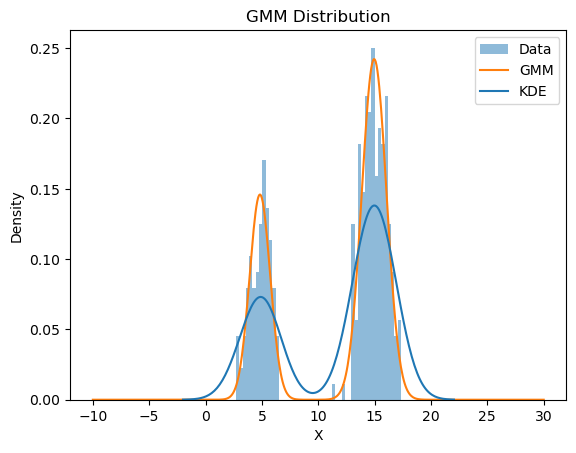

In [96]:
import numpy as np

# Convert the learned parameters to numpy arrays
weights_np = weights.numpy()
means_np = means.numpy()
covs_np = covs.numpy()

# Generate a range of values
x = np.linspace(-10, 30, 500)


# Calculate the probability density for each value
pdf = np.zeros_like(x)
for weight, mean, cov in zip(weights_np, means_np, covs_np):
    pdf += weight * np.exp(-(x - mean.flatten()) ** 2 / (2 * cov.flatten())) / np.sqrt(2 * np.pi * cov.flatten())



# Plot the histogram of the resulting distribution
plt.hist(data.numpy(), bins=50, density=True, alpha=0.5, label='Data')  # Assuming 'data' contains the original data points
plt.plot(x, pdf, label='GMM')
sns.kdeplot(data, label="KDE") # KDE of data
plt.xlabel('X')
plt.ylabel('Density')
plt.title('GMM Distribution')
plt.legend()